In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pwd

/content


In [3]:
%cd drive/My Drive/Colab Notebooks/Music Mood Recognition

/content/drive/My Drive/Colab Notebooks/Music Mood Recognition


In [4]:
!ls

1_Scraping.ipynb			    auth.py	 __pycache__
2_EDA					    data	 scrapes
3_Modeling_with_preexisting_features.ipynb  EDA.py	 Scraping.py
4_feature_engineering.ipynb		    funcs.ipynb
5_modeling-with-extracted-features.ipynb    funcs.py


In [5]:
pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=fa4c2bc28594b065570b000cdebfa87ab3d840378dfc074ce2f4d5111dc57c21
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [6]:
pip install spotipy

     |████████████████████████████████| 138 kB 12.0 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [7]:
import os
import pandas as pd
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import regex
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from ast import literal_eval
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from funcs import *

In [8]:
tqdm.pandas() # Registering instance of tqdm with pandas so I can check progress on .apply()

In [9]:
style.use('fivethirtyeight')

In [10]:
songs = pd.read_csv('./data/five_moods_30_samp.csv')

In [11]:
for folder in os.listdir('./scrapes/'):
    songs.loc[songs['mood'] == folder, 'filename'] = os.listdir(f'./scrapes/{folder}')

In [12]:
for folder in os.listdir('./scrapes/'):
    new_location = [f'./scrapes/{folder}/{file}' for file in os.listdir(f'./scrapes/{folder}')]
    songs.loc[songs['mood'] == folder, 'location'] = new_location     

In [29]:
rap_samp = songs[songs['mood'] == 'Happy']

In [30]:
rap_samp['location'].values[0]

'./scrapes/Happy/0030_Don Giovanni K 527 Act I Madamina il catalogo questo Instrumental Version.mp3'

In [31]:
x, sr = librosa.load(rap_samp['location'].values[0])

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


# **Calculating Energy, RMSE, and MFCC**
Energy is the total magnitude of the signal, RMSE stands for Root Mean Squared Energy. These are different ways of measuring loudness of a signal and require us to set windows of time.[1]

Calculating the Mel-Frequency Cepstral Coefficient (MFCC) involves many steps, but helps to create a non-linear representation of a sound's spectral envelope.[2] The steps are[3]:

Take the Fourier transform of (a windowed excerpt of) a signal.
Map the powers of the spectrum obtained above onto the mel scale, using triangular overlapping windows.
Take the logs of the powers at each of the mel frequencies.
Take the discrete cosine transform of the list of mel log powers, as if it were a signal.
The MFCCs are the amplitudes of the resulting spectrum.

In [13]:
# Creating empty columns to fill
songs['energy_calc'] = np.zeros_like(songs['location'])
songs['rms_calc'] = np.zeros_like(songs['location'])
songs['mfcc_calc'] = np.zeros_like(songs['location'])

In [14]:
for location in tqdm(songs['location']):
    new_features(songs, location)

100%|██████████| 150/150 [03:50<00:00,  1.53s/it]


In [15]:
#for location in tqdm(songs.iloc[:90]['location']):
#    new_features(songs, location, n_mfcc=12)

#for location in tqdm(songs.iloc[91:]['location']):
#    new_features(songs, location, n_mfcc=12)

In [16]:
# songs = songs.drop(index=90)

In [17]:
calc_features(songs)

100%|██████████| 150/150 [00:00<00:00, 15937.02it/s]


In [21]:
def split_features(data, nfilt=26): #12
    # I want to split each of the mfcc calculations to their own features    
    mfcc_mean_filters = pd.DataFrame(data['mfcc_mean'].tolist(),
             columns=[f'mfcc_mean_{str(i).zfill(2)}' for i in range(nfilt)])

    mfcc_std_filters = pd.DataFrame(data['mfcc_std'].tolist(),
                 columns=[f'mfcc_std_{str(i).zfill(2)}' for i in range(nfilt)])

    mfcc_min_filters = pd.DataFrame(data['mfcc_min'].tolist(),
                 columns=[f'mfcc_min_{str(i).zfill(2)}' for i in range(nfilt)])

    mfcc_max_filters = pd.DataFrame(data['mfcc_max'].tolist(),
                 columns=[f'mfcc_max_{str(i).zfill(2)}' for i in range(nfilt)])
    
    new_df = pd.concat([data, mfcc_mean_filters, 
                           mfcc_std_filters, 
                           mfcc_max_filters, 
                           mfcc_min_filters], axis=1)\
                  .drop(columns=['mfcc_calc',
                                'energy_calc',
                                'mfcc_mean',
                                'mfcc_std',
                                'mfcc_min',
                                'mfcc_max',
                                ])
    return new_df

In [22]:
nfilt = 26 #12
modeling_df = split_features(songs, nfilt)

In [ ]:
#columns_to_shift = modeling_df.columns[36:]

In [ ]:
#modeling_df.iloc[90:][columns_to_shift] = modeling_df.iloc[90:][columns_to_shift].shift(axis=0)

In [ ]:
#modeling_df.drop(90, inplace=True)

In [ ]:
#modeling_df.iloc[90]['mfcc_mean_00'] # Sanity check to make sure the mfcc_mean_00 is correct

In [ ]:
#modeling_df['energy_calc'] = modeling_df['energy_calc'].apply(lambda x: x.tolist())
#modeling_df['rms_calc'] = modeling_df['rms_calc'].apply(lambda x: x.tolist())
#modeling_df['mfcc_calc'] = modeling_df['mfcc_calc'].apply(lambda x: x.tolist())
#modeling_df['mfcc_mean'] = modeling_df['mfcc_mean'].apply(lambda x: x.tolist())
#modeling_df['mfcc_min'] = modeling_df['mfcc_min'].apply(lambda x: x.tolist())
#modeling_df['mfcc_max'] = modeling_df['mfcc_max'].apply(lambda x: x.tolist())

In [ ]:
#modeling_df['mfcc_max_00'].tail()

In [23]:
songs['mfcc_calc'][3].shape

(2584, 26)

In [24]:
'''modeling_df.to_csv('./data/ten_g_500_modeling_12filt.csv',
         sep='|',
         header=True,
         index=False,
         chunksize=10000,
         compression='gzip',
         encoding='utf-8')'''
modeling_df.to_csv('./data/five_g_500_modeling.csv', index=False)

In [33]:
hop_length = 512

In [34]:
frames = range(len("Happy"))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

NameError: ignored

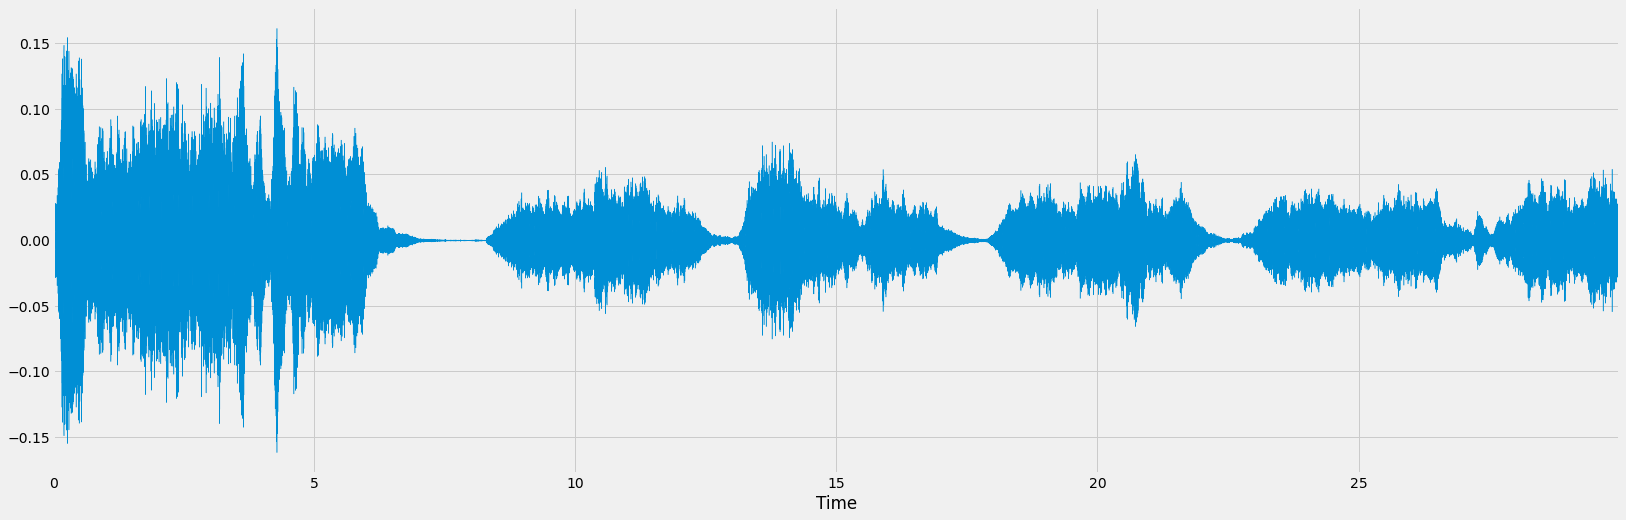

In [35]:
#hop_length = 256
plt.figure(figsize=(25, 8))
librosa.display.waveplot(x)
plt.plot(t, rms[0], label='RMS', linewidth=1.5, linestyle='--')
plt.plot(t, energy_norm, label='Energy', linewidth=1.5, linestyle='--')
plt.legend()